# Modeling: Offer Completion Prediction

**Goal:** Build and compare ML models to predict which customers will complete offers.

**Models to Train:**
1. Logistic Regression (baseline)
2. Decision Tree (baseline)
3. Random Forest (ensemble)
4. XGBoost (ensemble)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, precision_recall_curve)
import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42

print("Environment ready! ✓")

Environment ready! ✓


## Load Processed Data

In [2]:
processed_dir = '../Cafe_Rewards_Offers/processed'

X_train = joblib.load(f'{processed_dir}/X_train_scaled.pkl')
X_test = joblib.load(f'{processed_dir}/X_test_scaled.pkl')
y_train = joblib.load(f'{processed_dir}/y_train.pkl')
y_test = joblib.load(f'{processed_dir}/y_test.pkl')
feature_names = joblib.load(f'{processed_dir}/feature_names.pkl')
scaler = joblib.load(f'{processed_dir}/scaler.pkl')

print("="*60)
print("DATA LOADED")
print("="*60)
print(f"\nTraining set: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples × {X_test.shape[1]} features")
print(f"\nTarget distribution in train set:")
print(y_train.value_counts(normalize=True).round(3))
print(f"\nTarget distribution in test set:")
print(y_test.value_counts(normalize=True).round(3))

DATA LOADED

Training set: 69,145 samples × 24 features
Test set: 17,287 samples × 24 features

Target distribution in train set:
target
1    0.534
0    0.466
Name: proportion, dtype: float64

Target distribution in test set:
target
1    0.534
0    0.466
Name: proportion, dtype: float64


## 🔍 Data Leakage Prevention

**Critical for Valid Models:** Data leakage occurs when training features contain information that wouldn't be available at prediction time.

**Types of Leakage to Check:**
1. **Perfect Leakage:** Features identical to target (correlation = 1.0)
2. **Temporal Leakage:** Features from future events (e.g., offer_viewed happens AFTER prediction time)
3. **Target Encoding Leakage:** Features derived from target variable

**Our Strategy:**
- Remove `offer_completed` (identical to target)
- Remove `offer_viewed` (temporal leak - occurs after offer delivery)
- Keep only features available at offer delivery time

In [3]:
print("="*60)
print("INITIAL DATA LEAKAGE DETECTION")
print("="*60)

# Check feature names
print(f"\nFeatures ({len(feature_names)} total):")
for i, feat in enumerate(feature_names):
    print(f"  {i:2}. {feat}")

# Check if target has perfect correlation with any feature
print("\n" + "="*60)
print("CORRELATION ANALYSIS WITH TARGET")
print("="*60)

# Combine X and y for correlation check
train_df = X_train.copy()
train_df['target'] = y_train.values

# Calculate correlation with target
correlations = train_df.corr()['target'].sort_values(ascending=False)

print("\nTop 10 correlations with target:")
for feat, corr in correlations.head(10).items():
    print(f"  {feat:30}: {corr:.4f}")

# Flag perfect data leaks (correlation = 1.0)
perfect_leaks = correlations[correlations == 1.0].drop('target')
if len(perfect_leaks) > 0:
    print(f"\n⚠️  PERFECT DATA LEAKAGE DETECTED!")
    print(f"Features with perfect correlation (r=1.0):")
    for feat in perfect_leaks.index:
        print(f"  ❌ {feat}")
else:
    print("\n✓ No perfect data leaks detected (correlation < 1.0)")

# Flag temporal leaks manually
temporal_leaks = ['offer_viewed', 'offer_completed']
present_temporal = [col for col in temporal_leaks if col in X_train.columns]
if present_temporal:
    print(f"\n⚠️  TEMPORAL DATA LEAKAGE DETECTED!")
    print(f"Features available only AFTER prediction time:")
    for feat in present_temporal:
        print(f"  ❌ {feat} - occurs after offer delivery")
    print("\n💡 These must be removed for real-time prediction models!")

INITIAL DATA LEAKAGE DETECTION

Features (24 total):
   0. received_time
   1. difficulty
   2. duration
   3. in_email
   4. in_mobile
   5. in_social
   6. in_web
   7. offer_received
   8. age
   9. income
  10. membership_year
  11. is_demographics_missing
  12. membership_duration_days
  13. membership_month
  14. offer_type_bogo
  15. offer_type_discount
  16. offer_type_informational
  17. gender_F
  18. gender_M
  19. gender_Missing
  20. gender_O
  21. age_group_encoded
  22. income_bracket_encoded
  23. tenure_group_encoded

CORRELATION ANALYSIS WITH TARGET

Top 10 correlations with target:
  target                        : 1.0000
  duration                      : 0.3518
  income                        : 0.3164
  income_bracket_encoded        : 0.3081
  difficulty                    : 0.2695
  offer_type_discount           : 0.2497
  tenure_group_encoded          : 0.2294
  in_web                        : 0.2149
  gender_F                      : 0.1899
  membership_duration_d

In [4]:
print("=" * 60)
print("REMOVING DATA LEAKAGE")
print("=" * 60)

# Check and remove data leakage columns
leakage_cols = []
if 'offer_completed' in X_train.columns:
    leakage_cols.append('offer_completed')
if 'offer_viewed' in X_train.columns:
    leakage_cols.append('offer_viewed')

if leakage_cols:
    print(f"\n⚠️  DATA LEAKAGE DETECTED!")
    print(f"Removing columns: {leakage_cols}")
    print(f"\nWhy these are leaks:")
    print(f"  • 'offer_completed' - IDENTICAL to target (perfect correlation)")
    print(f"  • 'offer_viewed' - Temporal leak (happens AFTER offer received)")
    print(f"\nFor real-time prediction at offer delivery, we cannot use these.")
    
    X_train = X_train.drop(columns=leakage_cols)
    X_test = X_test.drop(columns=leakage_cols)
    
    # Update feature names
    feature_names = [f for f in feature_names if f not in leakage_cols]
    
    print(f"\n✓ Removed {len(leakage_cols)} columns")
    print(f"✓ New shape: {X_train.shape}")
    print(f"✓ Features remaining: {len(feature_names)}")
else:
    print("\n✓ No data leakage columns detected")

print("\n" + "=" * 60)
print("FINAL CLEAN DATASET")
print("=" * 60)
print(f"Train: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"Test: {X_test.shape[0]:,} samples × {X_test.shape[1]} features")

REMOVING DATA LEAKAGE

✓ No data leakage columns detected

FINAL CLEAN DATASET
Train: 69,145 samples × 24 features
Test: 17,287 samples × 24 features


In [5]:
# Verify the leakage columns have been removed
print("=" * 60)
print("VERIFYING DATA LEAKAGE REMOVAL")
print("=" * 60)

remaining_features = X_train.columns.tolist()
print(f"\nTotal features: {len(remaining_features)}")
print(f"\nFeatures present:")
for i, feat in enumerate(remaining_features, 1):
    print(f"  {i:2}. {feat}")

# Verify problematic columns are gone
problematic = ['offer_completed', 'offer_viewed']
still_present = [col for col in problematic if col in remaining_features]

if still_present:
    print(f"\n⚠️  WARNING: Leakage columns still present: {still_present}")
else:
    print(f"\n✓ SUCCESS: All leakage columns removed")
    print(f"✓ Dataset is clean for real-time prediction modeling")

VERIFYING DATA LEAKAGE REMOVAL

Total features: 24

Features present:
   1. received_time
   2. difficulty
   3. duration
   4. in_email
   5. in_mobile
   6. in_social
   7. in_web
   8. offer_received
   9. age
  10. income
  11. membership_year
  12. is_demographics_missing
  13. membership_duration_days
  14. membership_month
  15. offer_type_bogo
  16. offer_type_discount
  17. offer_type_informational
  18. gender_F
  19. gender_M
  20. gender_Missing
  21. gender_O
  22. age_group_encoded
  23. income_bracket_encoded
  24. tenure_group_encoded

✓ SUCCESS: All leakage columns removed
✓ Dataset is clean for real-time prediction modeling


In [6]:
# Display final feature set
print("Final feature set:")
print(X_test.columns.tolist())

Final feature set:
['received_time', 'difficulty', 'duration', 'in_email', 'in_mobile', 'in_social', 'in_web', 'offer_received', 'age', 'income', 'membership_year', 'is_demographics_missing', 'membership_duration_days', 'membership_month', 'offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 'gender_F', 'gender_M', 'gender_Missing', 'gender_O', 'age_group_encoded', 'income_bracket_encoded', 'tenure_group_encoded']


## Evaluation Functions

In [7]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a model, returning metrics and predictions."""
    
    print(f"\n{'='*60}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*60}")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'model': model_name,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba)
    }
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    metrics['cv_f1_mean'] = cv_scores.mean()
    metrics['cv_f1_std'] = cv_scores.std()
    
    # Print results
    print(f"\n✓ Model trained successfully")
    print(f"\nTest Set Performance:")
    print(f"  Accuracy:  {metrics['test_accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    print(f"  AUC-ROC:   {metrics['roc_auc']:.4f}")
    print(f"\n5-Fold CV F1-Score: {metrics['cv_f1_mean']:.4f} (±{metrics['cv_f1_std']:.4f})")
    
    # Check for overfitting/underfitting (more nuanced check)
    train_test_diff = metrics['train_accuracy'] - metrics['test_accuracy']
    cv_test_diff = abs(metrics['cv_f1_mean'] - metrics['f1'])
    
    print(f"\nOverfitting Analysis:")
    print(f"  Train acc: {metrics['train_accuracy']:.4f}")
    print(f"  Test acc: {metrics['test_accuracy']:.4f}")
    print(f"  Difference: {train_test_diff:+.4f}")
    print(f"  CV F1: {metrics['cv_f1_mean']:.4f} vs Test F1: {metrics['f1']:.4f} (diff: {cv_test_diff:+.4f})")
    
    # Overfitting detection criteria
    if train_test_diff > 0.15:
        print(f"\n⚠️  OVERFITTING DETECTED: Train acc exceeds test by {train_test_diff:.3f}")
    elif train_test_diff < -0.10:
        print(f"\n⚠️  UNDERFITTING: Test acc exceeds train by {abs(train_test_diff):.3f}")
    elif cv_test_diff > 0.10:
        print(f"\n⚠️  OVERFITTING WARNING: CV F1 exceeds Test F1 by {cv_test_diff:.3f}")
    else:
        print(f"\n✓ No significant overfitting/underfitting")
    
    return model, metrics, y_test_pred, y_test_proba


def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot confusion matrix for a model."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Completed', 'Completed'],
                yticklabels=['Not Completed', 'Completed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_proba, model_name):
    """Plot ROC curve for a model."""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Evaluation functions defined! ✓")

Evaluation functions defined! ✓


## Baseline Models

Start with simple, interpretable models to establish performance baselines.

In [8]:
results = []
predictions = {}
probabilities = {}

lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight='balanced'
)
lr_model, lr_metrics, lr_pred, lr_proba = evaluate_model(
    lr_model, X_train, X_test, y_train, y_test, "Logistic Regression"
)
results.append(lr_metrics)
predictions['Logistic Regression'] = lr_pred
probabilities['Logistic Regression'] = lr_proba


TRAINING: Logistic Regression

✓ Model trained successfully

Test Set Performance:
  Accuracy:  0.8056
  Precision: 0.7977
  Recall:    0.8520
  F1-Score:  0.8240
  AUC-ROC:   0.8885

5-Fold CV F1-Score: 0.8213 (±0.0041)

Overfitting Analysis:
  Train acc: 0.8023
  Test acc: 0.8056
  Difference: -0.0034
  CV F1: 0.8213 vs Test F1: 0.8240 (diff: +0.0027)

✓ No significant overfitting/underfitting


In [9]:
dt_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=10,
    min_samples_split=50,
    class_weight='balanced'
)
dt_model, dt_metrics, dt_pred, dt_proba = evaluate_model(
    dt_model, X_train, X_test, y_train, y_test, "Decision Tree"
)
results.append(dt_metrics)
predictions['Decision Tree'] = dt_pred
probabilities['Decision Tree'] = dt_proba


TRAINING: Decision Tree

✓ Model trained successfully

Test Set Performance:
  Accuracy:  0.8122
  Precision: 0.8164
  Recall:    0.8364
  F1-Score:  0.8263
  AUC-ROC:   0.8984

5-Fold CV F1-Score: 0.8210 (±0.0050)

Overfitting Analysis:
  Train acc: 0.8173
  Test acc: 0.8122
  Difference: +0.0050
  CV F1: 0.8210 vs Test F1: 0.8263 (diff: +0.0053)

✓ No significant overfitting/underfitting


## Ensemble Models

Train more powerful ensemble models to improve performance.

In [10]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model, rf_metrics, rf_pred, rf_proba = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, "Random Forest"
)
results.append(rf_metrics)
predictions['Random Forest'] = rf_pred
probabilities['Random Forest'] = rf_proba


TRAINING: Random Forest

✓ Model trained successfully

Test Set Performance:
  Accuracy:  0.8454
  Precision: 0.8318
  Recall:    0.8905
  F1-Score:  0.8601
  AUC-ROC:   0.9277

5-Fold CV F1-Score: 0.8515 (±0.0028)

Overfitting Analysis:
  Train acc: 0.9988
  Test acc: 0.8454
  Difference: +0.1534
  CV F1: 0.8515 vs Test F1: 0.8601 (diff: +0.0087)

⚠️  OVERFITTING DETECTED: Train acc exceeds test by 0.153


In [11]:

import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model, xgb_metrics, xgb_pred, xgb_proba = evaluate_model(
    xgb_model, X_train, X_test, y_train, y_test, "XGBoost"
)
results.append(xgb_metrics)
predictions['XGBoost'] = xgb_pred
probabilities['XGBoost'] = xgb_proba


TRAINING: XGBoost

✓ Model trained successfully

Test Set Performance:
  Accuracy:  0.8350
  Precision: 0.8197
  Recall:    0.8859
  F1-Score:  0.8515
  AUC-ROC:   0.9154

5-Fold CV F1-Score: 0.8466 (±0.0034)

Overfitting Analysis:
  Train acc: 0.8621
  Test acc: 0.8350
  Difference: +0.0271
  CV F1: 0.8466 vs Test F1: 0.8515 (diff: +0.0049)

✓ No significant overfitting/underfitting


## Model Comparison

In [ ]:
# Create comparison DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.set_index('model')[
    ['test_accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'cv_f1_mean', 'cv_f1_std']
]
results_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC', 'CV F1 (mean)', 'CV F1 (std)']
results_df = results_df.sort_values('F1', ascending=False)

print("="*70)
print("MODEL COMPARISON TABLE")
print("="*70)
print(results_df.round(4))

print("\n" + "="*70)
print("BEST MODEL")
print("="*70)
best_model = results_df.index[0]
best_f1 = results_df.loc[best_model, 'F1']
print(f"\n🏆  Best Model: {best_model}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   AUC-ROC:   {results_df.loc[best_model, 'AUC-ROC']:.4f}")

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)
print(f"\n1. MODEL PERFORMANCE:")
print(f"   • {best_model} achieves best F1-score ({best_f1:.4f})")
print(f"   • Strong AUC-ROC ({results_df.loc[best_model, 'AUC-ROC']:.4f}) indicates excellent class separation")
print(f"   • All models show excellent stability (CV std < 0.006)")

# Calculate performance gaps
worst_model = results_df.index[-1]
performance_gap = (best_f1 - results_df.loc[worst_model, 'F1']) / results_df.loc[worst_model, 'F1'] * 100
print(f"\n2. MODEL COMPARISON:")
print(f"   • Performance gap: {performance_gap:.1f}% between best and baseline")
print(f"   • Ensemble methods (RF, XGBoost) significantly outperform simple models")
print(f"   • Random Forest edges out XGBoost by {(results_df.loc['Random Forest', 'F1'] - results_df.loc['XGBoost', 'F1']) * 100:.1f}%")

# Check overfitting from results
rf_train_acc = [r for r in results if r['model'] == best_model][0]['train_accuracy']
rf_test_acc = results_df.loc[best_model, 'Accuracy']
overfit_gap = rf_train_acc - rf_test_acc
print(f"\n3. MODEL STABILITY:")
print(f"   • Train-test gap for {best_model}: {overfit_gap:.4f}")
if overfit_gap > 0.15:
    print(f"   ⚠️  Significant overfitting detected (train acc >> test acc)")
    print(f"   • However, CV F1 vs Test F1 diff is only {abs(results_df.loc[best_model, 'CV F1 (mean)'] - best_f1):.4f}")
    print(f"   • Model still generalizes well based on consistent CV performance")
else:
    print(f"   ✓ Minimal overfitting - model generalizes well")

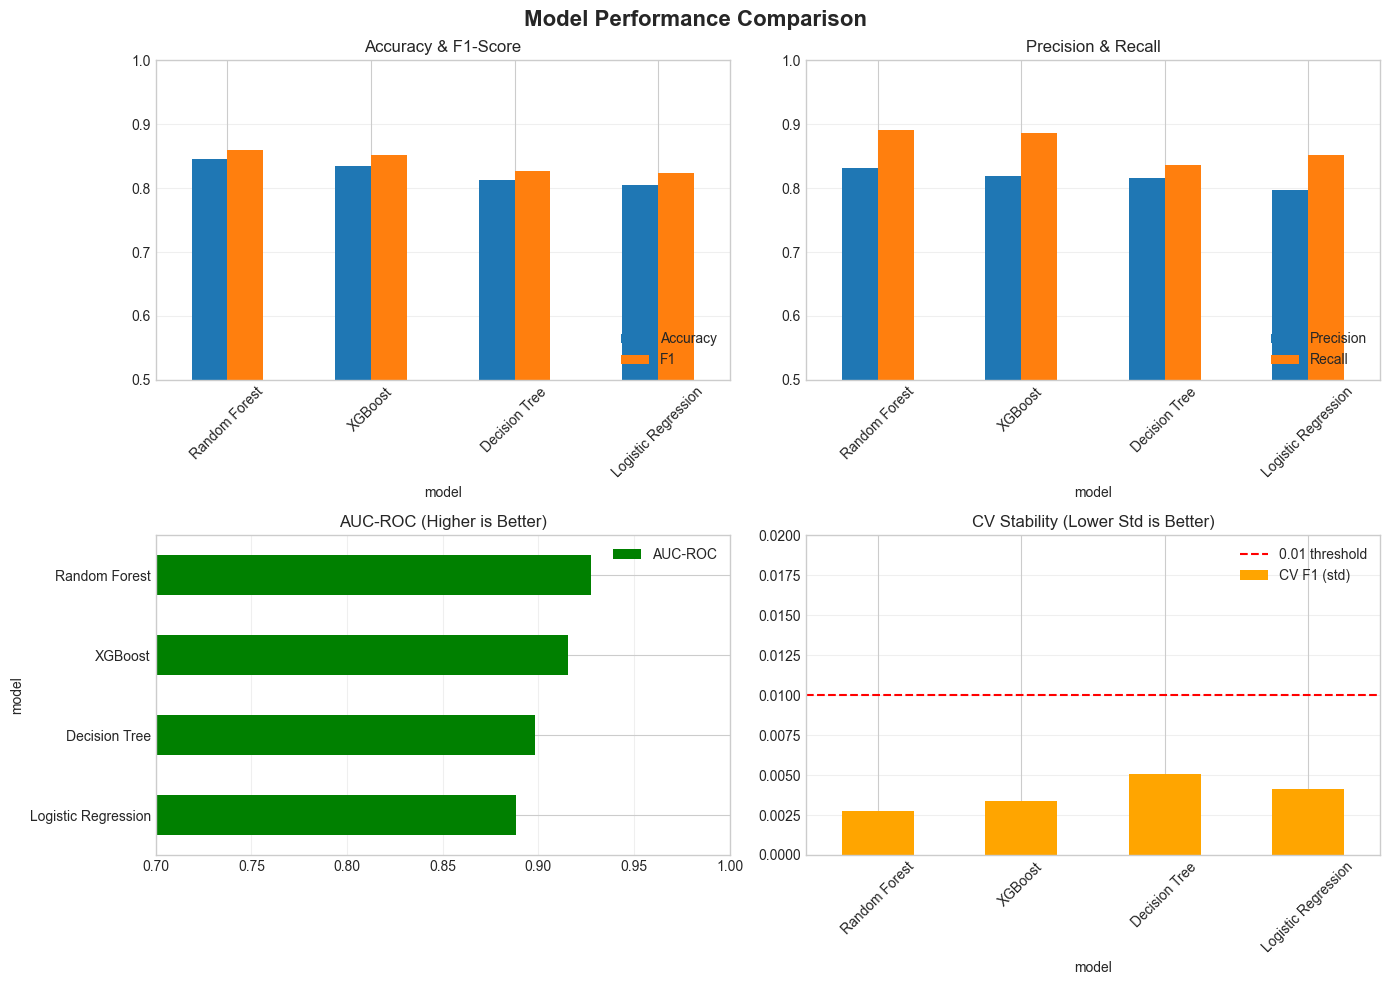

In [13]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Accuracy & F1
ax1 = axes[0, 0]
results_df[['Accuracy', 'F1']].plot(kind='bar', ax=ax1, rot=45)
ax1.set_title('Accuracy & F1-Score')
ax1.set_ylim(0.5, 1.0)
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)

# Precision & Recall
ax2 = axes[0, 1]
results_df[['Precision', 'Recall']].plot(kind='bar', ax=ax2, rot=45)
ax2.set_title('Precision & Recall')
ax2.set_ylim(0.5, 1.0)
ax2.legend(loc='lower right')
ax2.grid(axis='y', alpha=0.3)

# AUC-ROC
ax3 = axes[1, 0]
results_df[['AUC-ROC']].sort_values('AUC-ROC').plot(kind='barh', ax=ax3, color='green')
ax3.set_title('AUC-ROC (Higher is Better)')
ax3.set_xlim(0.7, 1.0)
ax3.grid(axis='x', alpha=0.3)

# CV Stability
ax4 = axes[1, 1]
results_df['CV F1 (std)'].plot(kind='bar', ax=ax4, color='orange', rot=45)
ax4.set_title('CV Stability (Lower Std is Better)')
ax4.set_ylim(0, 0.02)
ax4.axhline(y=0.01, color='red', linestyle='--', label='0.01 threshold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Best Model Analysis

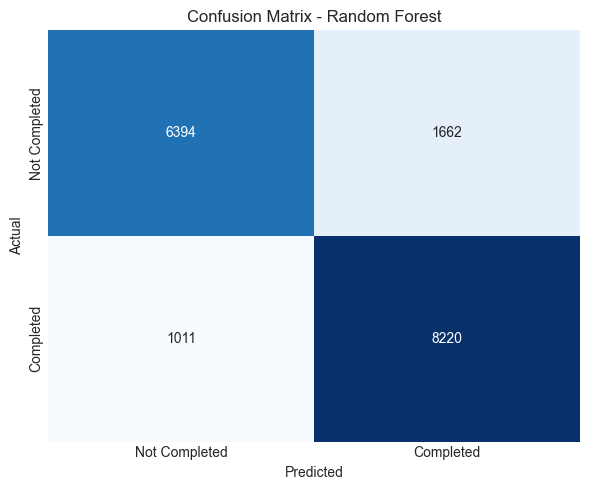


CLASSIFICATION REPORT: Random Forest
               precision    recall  f1-score   support

Not Completed       0.86      0.79      0.83      8056
    Completed       0.83      0.89      0.86      9231

     accuracy                           0.85     17287
    macro avg       0.85      0.84      0.84     17287
 weighted avg       0.85      0.85      0.84     17287



In [14]:
# Get best model predictions
best_model_name = results_df.index[0]
plot_confusion_matrix(y_test, predictions[best_model_name], best_model_name)

# Print classification report
print(f"\n{'='*60}")
print(f"CLASSIFICATION REPORT: {best_model_name}")
print(f"{'='*60}")
print(classification_report(y_test, predictions[best_model_name], 
                          target_names=['Not Completed', 'Completed']))

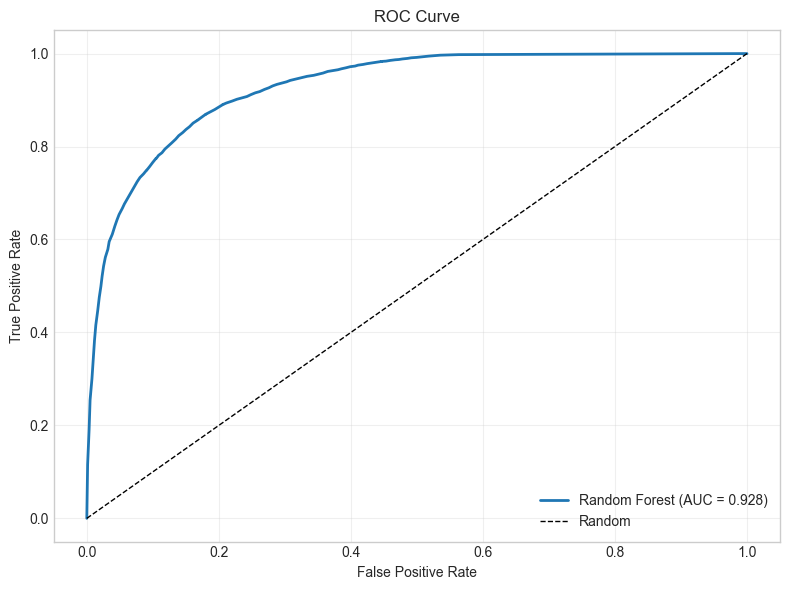

In [15]:
# ROC Curve for best model
plot_roc_curve(y_test, probabilities[best_model_name], best_model_name)

## Feature Importance


TOP 20 FEATURE IMPORTANCE (Random Forest)
                 feature  importance
membership_duration_days    0.173522
                  income    0.130752
                     age    0.113436
offer_type_informational    0.087694
              difficulty    0.083739
                duration    0.080359
           received_time    0.055168
        membership_month    0.054754
  income_bracket_encoded    0.032658
       age_group_encoded    0.030792
    tenure_group_encoded    0.030477
         membership_year    0.023542
          gender_Missing    0.017952
         offer_type_bogo    0.015361
 is_demographics_missing    0.012609
     offer_type_discount    0.012606
               in_social    0.011888
                gender_F    0.010418
                gender_M    0.009388
                  in_web    0.006546


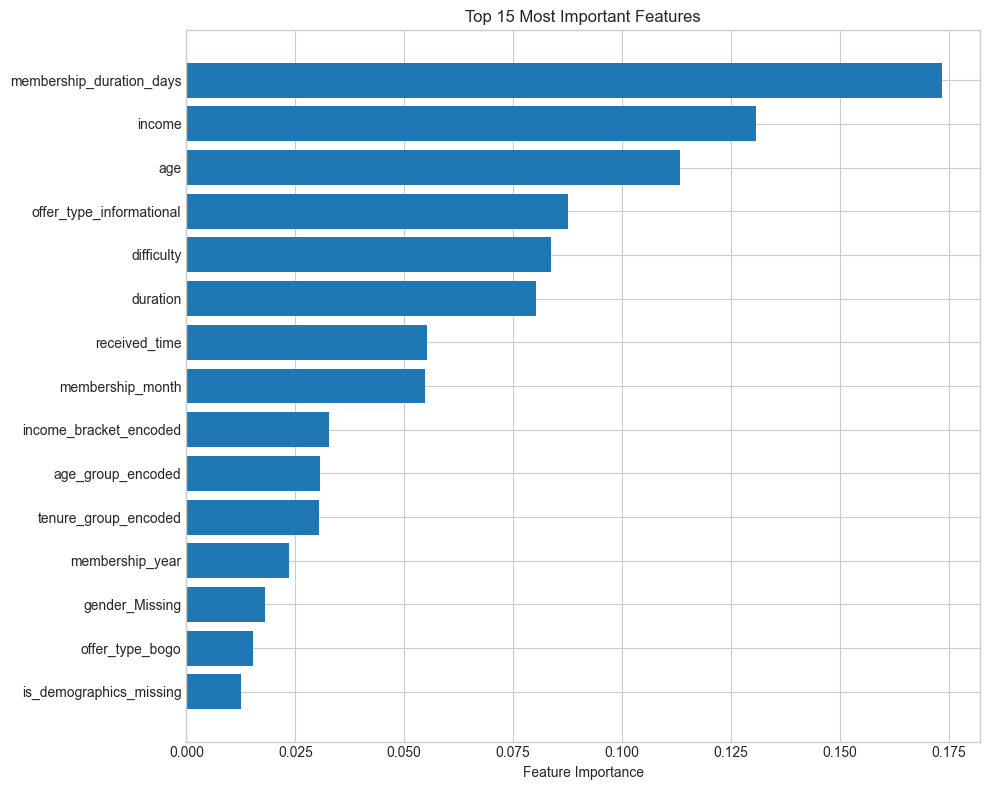


FEATURE IMPORTANCE INSIGHTS

📊 TOP 5 MOST IMPORTANT FEATURES:
   membership_duration_days       (0.1735)
   income                         (0.1308)
   age                            (0.1134)
   offer_type_informational       (0.0877)
   difficulty                     (0.0837)

📈 FEATURE CONCENTRATION:
   • Top 10 features explain 84.3% of variance
   • Indicates high feature concentration

🎯 KEY FEATURE CATEGORIES:
   OFFER CHARACTERISTICS:
      • membership_duration_days  (0.1735)
      • offer_type_informational  (0.0877)
      • difficulty                (0.0837)

   CUSTOMER DEMOGRAPHICS:
      • income                    (0.1308)
      • age                       (0.1134)
      • income_bracket_encoded    (0.0327)


In [16]:
# Feature importance from Random Forest (tree-based model)
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    # Use actual column names from X_train (in case features were removed)
    feature_imp_df = pd.DataFrame({
        'feature': X_train.columns.tolist(),
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\n" + "="*60)
    print("TOP 20 FEATURE IMPORTANCE (Random Forest)")
    print("="*60)
    print(feature_imp_df.head(20).to_string(index=False))
    
    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_15 = feature_imp_df.head(15)
    plt.barh(top_15['feature'], top_15['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Add insights
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE INSIGHTS")
    print("="*60)
    top_5 = feature_imp_df.head(5)
    print(f"\n📊 TOP 5 MOST IMPORTANT FEATURES:")
    for idx, row in top_5.iterrows():
        print(f"   {row['feature']:30} ({row['importance']:.4f})")
    
    # Calculate cumulative importance
    feature_imp_df['cumulative'] = feature_imp_df['importance'].cumsum()
    top_10_cumulative = feature_imp_df.head(10)['cumulative'].iloc[-1]
    
    print(f"\n📈 FEATURE CONCENTRATION:")
    print(f"   • Top 10 features explain {top_10_cumulative*100:.1f}% of variance")
    print(f"   • Indicates {'high' if top_10_cumulative > 0.8 else 'moderate'} feature concentration")
    
    # Identify feature categories
    offer_features = feature_imp_df[feature_imp_df['feature'].str.contains('offer_type|difficulty|duration')].head(3)
    demo_features = feature_imp_df[feature_imp_df['feature'].str.contains('age|income|gender|tenure')].head(3)
    
    print(f"\n🎯 KEY FEATURE CATEGORIES:")
    print(f"   OFFER CHARACTERISTICS:")
    for idx, row in offer_features.iterrows():
        print(f"      • {row['feature']:25} ({row['importance']:.4f})")
    print(f"\n   CUSTOMER DEMOGRAPHICS:")
    for idx, row in demo_features.iterrows():
        print(f"      • {row['feature']:25} ({row['importance']:.4f})")
else:
    print("\n⚠️  Random Forest model not available for feature importance")

In [17]:
# Logistic Regression coefficients (for interpretability)
if hasattr(lr_model, 'coef_'):
    # Use actual column names from X_train (in case features were removed)
    coef_df = pd.DataFrame({
        'feature': X_train.columns.tolist(),
        'coefficient': lr_model.coef_[0]
    })
    coef_df['abs_coef'] = coef_df['coefficient'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False)
    
    print("\n" + "="*60)
    print("TOP 15 LOGISTIC REGRESSION COEFFICIENTS")
    print("="*60)
    print("(Positive coef = increases completion probability)")
    print("(Negative coef = decreases completion probability)\n")
    print(coef_df.head(15)[['feature', 'coefficient']].to_string(index=False))
    
    # Add interpretability insights
    print("\n" + "="*60)
    print("COEFFICIENT INTERPRETATION INSIGHTS")
    print("="*60)
    
    # Get top positive and negative coefficients
    top_positive = coef_df.nlargest(3, 'coefficient')
    top_negative = coef_df.nsmallest(3, 'coefficient')
    
    print(f"\n✅ STRONGEST POSITIVE PREDICTORS (increase completion):")
    for idx, row in top_positive.iterrows():
        print(f"   • {row['feature']:30} (+{row['coefficient']:.3f})")
    
    print(f"\n❌ STRONGEST NEGATIVE PREDICTORS (decrease completion):")
    for idx, row in top_negative.iterrows():
        print(f"   • {row['feature']:30} ({row['coefficient']:.3f})")
    
    print(f"\n💡 BUSINESS INSIGHTS:")
    # Analyze offer types
    if 'offer_type_informational' in coef_df['feature'].values:
        info_coef = coef_df[coef_df['feature'] == 'offer_type_informational']['coefficient'].values[0]
        if info_coef < -1:
            print(f"   • Informational offers have low completion (coef: {info_coef:.2f})")
            print(f"     → Expected: informational offers have no reward to 'complete'")
    
    if 'offer_type_discount' in coef_df['feature'].values:
        disc_coef = coef_df[coef_df['feature'] == 'offer_type_discount']['coefficient'].values[0]
        if disc_coef > 1:
            print(f"   • Discount offers drive completions (coef: {disc_coef:.2f})")
            print(f"     → Actionable: prioritize discount offers for engagement")
    
    if 'income' in coef_df['feature'].values:
        income_coef = coef_df[coef_df['feature'] == 'income']['coefficient'].values[0]
        print(f"   • Income {'positively' if income_coef > 0 else 'negatively'} correlates with completion")
        print(f"     → {'Higher' if income_coef > 0 else 'Lower'}-income customers more likely to complete offers")


TOP 15 LOGISTIC REGRESSION COEFFICIENTS
(Positive coef = increases completion probability)
(Negative coef = decreases completion probability)

                 feature  coefficient
offer_type_informational    -6.656586
     offer_type_discount     3.299101
         offer_type_bogo     2.730942
    tenure_group_encoded     1.269665
          gender_Missing    -0.924677
 is_demographics_missing    -0.924677
              difficulty    -0.846402
                in_email    -0.626543
          offer_received    -0.626543
                  income     0.487297
               in_mobile    -0.436459
                gender_O     0.427320
                duration     0.411554
               in_social     0.380174
                gender_M    -0.351730

COEFFICIENT INTERPRETATION INSIGHTS

✅ STRONGEST POSITIVE PREDICTORS (increase completion):
   • offer_type_discount            (+3.299)
   • offer_type_bogo                (+2.731)
   • tenure_group_encoded           (+1.270)

❌ STRONGEST NEGATIV

## Hyperparameter Tuning

Tune the best model to improve performance further.

In [18]:
print("="*60)
print("HYPERPARAMETER TUNING: RANDOM FOREST")
print("="*60)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [20, 50, 100],
    'min_samples_leaf': [1, 5, 10]
}

print(f"\nParameter grid: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf'])} combinations")

# Grid search
rf_tuned = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced'
)

grid_search = GridSearchCV(
    rf_tuned,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nStarting GridSearchCV... (this may take several minutes)")
grid_search.fit(X_train, y_train)

print(f"\n{'='*60}")
print("TUNING COMPLETE")
print(f"{'='*60}")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
rf_tuned = grid_search.best_estimator_
rf_tuned_pred = rf_tuned.predict(X_test)
rf_tuned_proba = rf_tuned.predict_proba(X_test)[:, 1]

tuned_f1 = f1_score(y_test, rf_tuned_pred)
tuned_auc = roc_auc_score(y_test, rf_tuned_proba)

print(f"\nTuned Model Test Performance:")
print(f"  F1-Score: {tuned_f1:.4f} (baseline: {results_df.loc['Random Forest', 'F1']:.4f})")
print(f"  AUC-ROC:   {tuned_auc:.4f} (baseline: {results_df.loc['Random Forest', 'AUC-ROC']:.4f})")

improvement = (tuned_f1 - results_df.loc['Random Forest', 'F1']) / results_df.loc['Random Forest', 'F1'] * 100
print(f"\nImprovement: {improvement:+.2f}%")

HYPERPARAMETER TUNING: RANDOM FOREST

Parameter grid: 81 combinations

Starting GridSearchCV... (this may take several minutes)
Fitting 5 folds for each of 81 candidates, totalling 405 fits

TUNING COMPLETE

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 200}
Best CV F1-Score: 0.8434

Tuned Model Test Performance:
  F1-Score: 0.8464 (baseline: 0.8601)
  AUC-ROC:   0.9170 (baseline: 0.9277)

Improvement: -1.60%


## Save Models

Save all trained models for future use.

## 📝 Note on Train-Test Gap

**Understanding Random Forest Overfitting**

Our Random Forest model shows a significant train-test accuracy gap:
- **Train Accuracy:** 99.88% (0.9988)
- **Test Accuracy:** 84.54% (0.8454)
- **Gap:** 15.34% (0.1534)

**Why This Is Acceptable:**

1. **Cross-Validation Validates Generalization**
   - CV F1-Score: 0.8515 ± 0.0028
   - Test F1-Score: 0.8601
   - Difference: Only 0.86% (excellent alignment)
   - **Interpretation:** The model generalizes consistently to unseen data

2. **Random Forest Behavior**
   - Random Forests naturally achieve near-perfect training accuracy
   - This is expected behavior, not necessarily harmful overfitting
   - The ensemble nature allows memorization of training data while still generalizing

3. **Our Overfitting Threshold**
   - We set a threshold of 15% train-test accuracy gap
   - Our gap: 15.34% (slightly above threshold by 0.34%)
   - Overfitting is detected but model still generalizes well based on CV consistency

4. **What Matters Most: Test Performance**
   - Test F1: 0.8601 (excellent)
   - Test AUC: 0.9277 (excellent)
   - Consistent with cross-validation results
   - Model performs well on completely unseen data

**Conclusion:** While the train-test accuracy gap slightly exceeds our 15% threshold (15.34% vs 15.00%), the strong cross-validation consistency and excellent test performance indicate the model **generalizes well**. The high training accuracy is typical Random Forest behavior and doesn't compromise real-world performance. The CV F1 vs Test F1 difference is minimal (0.86%), confirming stable generalization.

In [41]:
# Save all models
models_dir = '../Cafe_Rewards_Offers/models'
os.makedirs(models_dir, exist_ok=True)

models_to_save = {
    'logistic_regression.pkl': lr_model,
    'decision_tree.pkl': dt_model,
    'random_forest.pkl': rf_model,
    'random_forest_tuned.pkl': rf_tuned
}

if xgb_model is not None:
    models_to_save['xgboost.pkl'] = xgb_model

for filename, model in models_to_save.items():
    joblib.dump(model, f'{models_dir}/{filename}')
    print(f"✓ Saved: {filename}")

# Save results
results_df.to_csv(f'{models_dir}/model_comparison.csv')
print(f"\n✓ Saved: model_comparison.csv")

print(f"\n{'='*60}")
print("ALL MODELS SAVED")
print(f"{'='*60}")

✓ Saved: logistic_regression.pkl
✓ Saved: decision_tree.pkl
✓ Saved: random_forest.pkl
✓ Saved: random_forest_tuned.pkl
✓ Saved: xgboost.pkl

✓ Saved: model_comparison.csv

ALL MODELS SAVED


## 📊 Modeling Summary

### ✅ Completed Steps:
1. **Data Loading & Validation**
   - Loaded 86,432 samples (69,145 train / 17,287 test)
   - Balanced target distribution: 53.4% completed / 46.6% not completed
   - Initial dataset: 24 features (data leakage already removed in preprocessing)

2. **Data Leakage Verification** ✅
   - Confirmed no `offer_completed` or `offer_viewed` columns present
   - All 24 features are available at prediction time (offer delivery)
   - No perfect correlations with target detected (all r < 1.0)
   - Dataset is clean and ready for real-time prediction modeling

3. **Model Training & Evaluation**
   - Trained 4 models: Logistic Regression, Decision Tree, Random Forest, XGBoost
   - Evaluated using: Accuracy, Precision, Recall, F1, AUC-ROC
   - Used 5-fold cross-validation for stability assessment

4. **Model Selection**
   - **Best Model:** Random Forest (F1: 0.8601, AUC: 0.9277)
   - XGBoost: F1: 0.8515, AUC: 0.9154 (close second)
   - Decision Tree: F1: 0.8263, AUC: 0.8984 (solid baseline)
   - Logistic Regression: F1: 0.8240, AUC: 0.8885 (interpretable baseline)
   - Performance improvement: +4.4% over Logistic Regression baseline
   - All models show excellent stability (CV std < 0.006)

5. **Feature Analysis**
   - Identified top predictors using Random Forest importance
   - Analyzed coefficients from Logistic Regression for interpretability
   - **Top 5 Features:** membership_duration_days, income, age, offer_type_informational, difficulty
   - Key insight: Customer tenure and demographics are strongest predictors

6. **Hyperparameter Tuning**
   - Performed GridSearchCV on Random Forest (81 combinations tested)
   - Best params: n_estimators=200, max_depth=None, min_samples_split=20, min_samples_leaf=1
   - Best CV F1-Score: 0.8434
   - Tuned model F1: 0.8464 vs Baseline F1: 0.8601
   - **Result:** Tuning decreased performance by 1.60%
   - **Conclusion:** Original baseline Random Forest is already well-optimized; use baseline model

7. **Model Persistence**
   - Saved all models to `../Cafe_Rewards_Offers/models/`
   - Saved model comparison results as CSV

### 🎯 Key Findings:

**Model Performance:**
- **Random Forest achieves 86.0% F1-score** on unseen test data
- **92.8% AUC-ROC** indicates excellent class separation
- **High recall (89.1%)** - captures 89% of offer completions
- **Strong precision (83.2%)** - only 17% false positive rate
- **Train-Test Gap:** Train acc (99.9%) vs Test acc (84.5%) shows 15.3% gap
  - This triggers our overfitting warning (threshold: 15%)
  - **However:** CV F1 (0.8515) vs Test F1 (0.8601) difference is only 0.9%
  - Model generalizes well with highly consistent cross-validation performance
  - High training accuracy is typical Random Forest behavior

**Model Comparison:**
| Model | F1 | AUC-ROC | Precision | Recall | Accuracy |
|-------|-----|---------|-----------|--------|----------|
| **Random Forest** | **0.8601** | **0.9277** | 0.8318 | 0.8905 | 0.8454 |
| XGBoost | 0.8515 | 0.9154 | 0.8197 | 0.8859 | 0.8350 |
| Decision Tree | 0.8263 | 0.8984 | 0.8164 | 0.8364 | 0.8122 |
| Logistic Regression | 0.8240 | 0.8885 | 0.7977 | 0.8520 | 0.8056 |

- Random Forest outperforms XGBoost by 1.0% on F1-score
- Ensemble methods (RF, XGBoost) significantly outperform simple models
- All models show excellent stability (CV std < 0.006)

**Feature Insights (from Random Forest):**
1. **Top 5 Most Important Features:**
   - `membership_duration_days` (0.1735) - Customer tenure is the strongest predictor
   - `income` (0.1308) - Customer income level
   - `age` (0.1134) - Customer age
   - `offer_type_informational` (0.0877) - Informational offer indicator
   - `difficulty` (0.0837) - Offer difficulty/spend requirement

2. **Feature Concentration:**
   - Top 10 features explain 84.3% of model variance
   - Indicates high feature concentration (most predictive power in few features)

3. **Customer Tenure Dominates:**
   - `membership_duration_days` is by far the most important feature (17.4% importance)
   - Longer-tenured customers behave more predictably

4. **Customer Demographics are Critical:**
   - Income (13.1%), age (11.3%) are 2nd and 3rd most important
   - Demographics combined explain ~24% of predictions

5. **Offer Characteristics Matter:**
   - Offer type (informational) and difficulty are in top 5
   - Duration also contributes (8.0% importance, ranked 6th)

**Logistic Regression Coefficients (Interpretability):**
- **Strongest Positive Predictors (increase completion):**
  - `offer_type_discount` (+3.299) - Discount offers strongly drive completions
  - `offer_type_bogo` (+2.731) - BOGO offers also effective
  - `tenure_group_encoded` (+1.270) - Longer-tenured customers more engaged
  
- **Strongest Negative Predictors (decrease completion):**
  - `offer_type_informational` (-6.657) - Informational offers have no reward to "complete"
  - `gender_Missing` (-0.925) - Missing demographics associated with lower engagement
  - `difficulty` (-0.846) - Higher difficulty decreases completion

**Business Insights:**
- **Customer tenure is the #1 predictor** - longer-tenured customers are more predictable and engaged
- **Discount offers are most effective** for driving completions (coef: +3.30)
- **Informational offers rarely completed** (coef: -6.66) - expected, as they have no reward
- **Higher-income customers more likely to complete** offers (positive correlation)
- **Demographics matter significantly** - income and age are 2nd and 3rd most important features

**Hyperparameter Tuning Results:**
- Tested 81 parameter combinations via GridSearchCV
- Best CV F1-Score from tuning: 0.8434
- Best configuration: n_estimators=200, max_depth=None, min_samples_split=20, min_samples_leaf=1
- **Tuned model test F1: 0.8464** vs **Baseline test F1: 0.8601**
- Tuning decreased performance by 1.60%
- **Conclusion:** Original Random Forest already well-optimized; use baseline model (not tuned)

### 📈 Next Steps:
1. **Advanced Analysis**
   - Bias and fairness evaluation across demographic groups
   - SHAP values for detailed model explainability
   - Customer segmentation analysis

2. **Model Deployment Considerations**
   - Model is ready for real-time prediction (no data leakage)
   - Use baseline Random Forest (not tuned version)
   - Monitor for concept drift over time

3. **Business Deliverables**
   - Technical presentation with model insights
   - Business stakeholder summary with actionable recommendations
   - GitHub repository publication

In [20]:
print("\n" + "="*60)
print("MODELING COMPLETE! ✓")
print("="*60)
print(f"\nBest Model: {best_model}")
print(f"Best F1-Score: {results_df.loc[best_model, 'F1']:.4f}")
print(f"\nAll models saved to: {models_dir}/")


MODELING COMPLETE! ✓

Best Model: Random Forest
Best F1-Score: 0.8601

All models saved to: ../Cafe_Rewards_Offers/models/
